# Replication of results for the HIV model - vector QoI

This is a notebook to recreate the results of Section 8 of

W.N. Edeling, "On the deep active subspace method", (submitted), 2021.

Here we will apply the deep active subspace method to an HIV model consisting of 7 coupled ordinary differential equations, with 27 uncertain input parameters, see the article above for more information.

This notebook contains the results for the vector-valued QoI case. For the scalar QoI, see `HIV.ipynb`.

### Requirements

The Deep Active Subspace method (original reference below) is implemented in [EasySurrogate](https://github.com/wedeling/EasySurrogate). To install, simply uncomment the `!pip install` line below. Furthermore, `scipy`, `seaborn` and `pandas` are also required.

Tripathy, R., & Bilionis, I. (2019, August). Deep active subspaces: A scalable method for high-dimensional uncertainty propagation. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 59179, p. V001T02A074). American Society of Mechanical Engineers.

In [1]:
#!pip install easysurrogate==0.18

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import easysurrogate as es
from scipy import linalg
import pandas as pd
import seaborn as sns

In [2]:
# select the seismic color scheme
plt.rcParams['image.cmap'] = 'seismic'

### EasySurrogate campaign

EasySurrogate's basic object is called a `campaign', which handles the data. 

In [3]:
# Create EasySurrogate campaign
campaign = es.Campaign()

### Load training data

Here we use the campaign to load the training data, which is precomputed and stored in the `my_samples_w_norm_deriv.hdf5` file, which also contains the finite-difference gradients of $\lVert {\bf f}\rVert_2$.

In [4]:
# number of inputs
D = 27
times = np.array([5, 15, 24, 38, 40, 45, 50, 55, 65, 90, 140, 500, 750,
                  1000, 1600, 1800, 2000, 2200, 2400, 2800, 3400])
T = times.size

# input - output data
data = campaign.load_hdf5_data(file_path='./my_samples_w_norm_deriv.hdf5')
params = data['inputs']
samples = data['outputs']
derivatives = data['derivatives_norm']

# size of QoI
n_out = samples.shape[1]

# If true, the gradient ||f||_2 is computed
norm = True

Loaded derivatives_norm
Loaded inputs
Loaded outputs


### Train an artificial neural network

We first train a vanilla artificial neural network without a DAS layer. The inputs are already normalized to lie within $[-1, 1]$, and we standardize the output.

In [5]:
##########################
# Train an ANN surrogate #
##########################

ann_surrogate = es.methods.ANN_Surrogate()
# train ANN. the input parameters are already scaled to [-1, 1], so no need to
# standardize these
ann_surrogate.train(params, samples, 
                n_iter=10000, n_layers=4, n_neurons=50, test_frac = 0.0, 
                batch_size = 64, lamb=0.0, standardize_X=False)
# dict with some dimenions of the ANN
# dims = ann_surrogate.get_dimensions()

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  1000/1000 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 27
Loss function = squared
Number of neurons per hidden layer = 50
Number of output neurons = 21
Activation hidden layers = tanh
Activation output layer = linear
This neural network has 7571 weights.
Training Artificial Neural Network...
Batch 0 learning rate 0.001 loss: 1.1870494632047568
Batch 1000 learning rate 0.001 loss: 0.004600418817667511
Batch 2000 learning rate 0.001 loss: 0.00181337265256882
Batch 3000 learning rate 0.001 loss: 0.001272789939468548
Batch 4000 learning rate 0.001 loss: 0.0008229761642325955
Batch 5000 learning rate 0.001 loss: 0.0007313781836412727
Batch 6000 learning rate 0.001 loss: 0.0004362010691357661
Batch 7000 learning rate 0.001 loss: 0.0004852832062028804
Batch 8000 learning rate 0.001 loss: 0.00038866550755262727
Batch 9000 learning rate 0.001 loss: 0.0003572961401087944


### Compute the original active subspace of the ANN

Here we solve the original active subspace of the neural network

In [6]:
# Number of Monte Carlo samples
n_mc = params.shape[0]

# gradient matrix for the ANN
C_ann = 0.0

# compute the derivative of the neural net output for every input
for i, param in enumerate(params):
    df_dx = ann_surrogate.derivative(param, norm=norm)
    # construct the C matrix
    C_ann += np.dot(df_dx, df_dx.T) / n_mc

# Solve eigenproblem
eigvals_ann, eigvecs_ann = linalg.eigh(C_ann)

# Sort the eigensolutions in the descending order of eigenvalues
order_ann = eigvals_ann.argsort()[::-1]
eigvals_ann = eigvals_ann[order_ann]
eigvecs_ann = eigvecs_ann[:, order_ann]

### Compute the reference active subspace

Here we compute the reference active subspace, by using the derivative data from https://github.com/paulcon/as-data-sets/tree/master/HIV

In [7]:
C_ref = 0.0
for i in range(derivatives.shape[0]):
    C_ref += np.dot(derivatives[i].reshape([-1,1]), derivatives[i].reshape([1, -1])) / n_mc
eigvals_ref, eigvecs_ref = linalg.eigh(C_ref)

# Sort the eigensolutions in the descending order of eigenvalues
order_ref = eigvals_ref.argsort()[::-1]
eigvals_ref = eigvals_ref[order_ref]
eigvecs_ref = eigvecs_ref[:, order_ref]

### Select $d$

We we select $d=2$, i.e. we are constructing a 2D active subspace.

In [8]:
########################################
# choose the active subspace dimension #
########################################
d = 2

### Train a deep active subspace network

Below we train a deep active subspace network, using $d=1$ in the DAS layer.

In [9]:
#####################
# train DAS network #
#####################

das_surrogate = es.methods.DAS_Surrogate()
das_surrogate.train(params, samples, d, n_iter=10000, n_layers=4, n_neurons=50, test_frac = 0.0, 
                batch_size = 64, standardize_X=False)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  1000/1000 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 27
Loss function = squared
Number of neurons per hidden layer = 50
Number of output neurons = 21
Activation hidden layers = tanh
Activation output layer = linear
This neural network has 3825 weights.
Training Deep Active Subspace Neural Network...
Batch 0 learning rate 0.001 loss: 1.0752576072862656
Batch 1000 learning rate 0.001 loss: 0.07071298289455843
Batch 2000 learning rate 0.001 loss: 0.08363995763130477
Batch 3000 learning rate 0.001 loss: 0.07318818246964656
Batch 4000 learning rate 0.001 loss: 0.07672557712538486
Batch 5000 learning rate 0.001 loss: 0.07192496077718882
Batch 6000 learning rate 0.001 loss: 0.0669230447976326
Batch 7000 learning rate 0.001 loss: 0.04922876442355516
Batch 8000 learning rate 0.001 loss: 0.07654798948398873
Batch 9000 learning rate 0.001 loss: 0.0771101529107155


### "Internal consistency" DAS network

In theorem 5.2, we proved that the DAS network is "internally consistent" with the original active subspace method, in the sense that $\mathrm{span}(V_1) = \mathrm{span}(W_1)$. Here, $W_1$ is the DAS projection matrix, and $V_1$ is the projection matrix formed by the $d$ dominant eigenvectors of 

\begin{align}
 C_{DAS} = \int \left(\frac{\partial \widetilde{f}}{\partial {\bf x}}\right)\left(\frac{\partial \widetilde{f}}{\partial {\bf x}}\right)^T p({\bf x})d{\bf x} =  
 \int W_1 \left(\frac{\partial \widetilde{f}}{\partial {\bf y}}\right)\left(\frac{\partial \widetilde{f}}{\partial {\bf y}}\right)^TW_1^T p(\bf x)d{\bf x}
=\\
[V_1\;\; V_2]\left[
\begin{matrix}
\Lambda_1 & 0 \\
0 & \Lambda_2
\end{matrix} 
 \right][V_1\;\; V_2]^T = W_1\overline{C}_1W_1^T
\end{align}

See the article for details. Our purpose here is to numerically check the validity of $\mathrm{span}(V_1) = \mathrm{span}(W_1)$, using the `scipy.linalg.subspace_angles` method, which should yield a zero angle between $V_1$ and $W_1$.

In [10]:
# the gradient matrix computed of the DAS network, computed using the classical AS method
C_das = 0.0
# the MC approximation of C_1 = (df/dh)(df/dh)^T
C_1 = 0.0

# Compute C1 and C_das
das_samples = np.zeros([n_mc, samples.shape[1]])
for i, param in enumerate(params):
    # compute the derivative of f at the input layer (needed for C_das)
    df_dx = das_surrogate.derivative(param, norm=norm)
    # store predictions for later
    das_samples[i] = das_surrogate.predict(param)
    # derivative of f in the DAS layer (needed for C_1)
    df_dh = das_surrogate.neural_net.layers[1].delta_hy.reshape([-1,1])
    # update C_1 and C_das
    C_1 += np.dot(df_dh, df_dh.T) / n_mc
    C_das += np.dot(df_dx, df_dx.T) / n_mc

# solve eigenvalue problem for C_das
eigvals_C_das, V = linalg.eigh(C_das)

# Sort the eigensolutions in the descending order of eigenvalues
order = eigvals_C_das.argsort()[::-1]
eigvals_C_das = eigvals_C_das[order]
V = V[:, order]
V_1 = V[:, 0:d]

# the DAS weight matrix of the first hidden layer
W_1 = das_surrogate.neural_net.layers[1].W

print("The subspace angles between V1 and W1 are %s" % linalg.subspace_angles(V_1, W_1))

y_das = np.dot(W_1.T, params.T).T

# compute eigenvalues / vectors of C_1 and sort
eigvals_C_1, eigvecs_C_1 = linalg.eigh(C_1)
order = eigvals_C_1.argsort()[::-1]
eigvals_C_1 = eigvals_C_1[order]
eigvecs_C_1 = eigvecs_C_1[:, order]

The subspace angles between V1 and W1 are [1.11352732e-15 4.15326482e-16]


### Recreate the eigenvalue plots

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


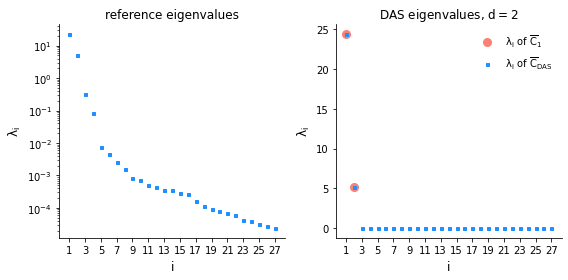

In [11]:
####################
# plot eigenvalues #
####################

fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(121, yscale='log', title='reference eigenvalues')
ax.set_ylabel(r'$\lambda_i$', fontsize=12)
ax.set_xlabel(r'$i$', fontsize=12)
ax.plot(range(1, D + 1), eigvals_ref, 's', color='dodgerblue',  markersize=3,)
ax.set_xticks(np.arange(1, D + 1, 2))
#
ax2 = fig.add_subplot(122, title=r'DAS eigenvalues, $d=%d$' % d)
ax2.set_ylabel(r'$\lambda_i$', fontsize=12)
ax2.set_xlabel(r'$i$', fontsize=12)
ax2.plot(range(1, d + 1), eigvals_C_1, 'o', color='salmon', markersize=8, 
         label = '%s of %s' % (r'$\lambda_i$', r'$\overline{C}_1$'))
ax2.plot(range(1, D + 1), eigvals_C_das, 's', color='dodgerblue', markersize=3,
         label='%s of %s' % (r'$\lambda_i$', r'$\overline{C}_{DAS}$'))
ax2.set_xticks(np.arange(1, D + 1, 2))
sns.despine(top=True)
plt.legend(loc=0, frameon=False)
plt.tight_layout()

### Recreate the active subspace plot

This samples 1000 new model evaluations to generate the validation plot. This will take a couple of minutes to complete.

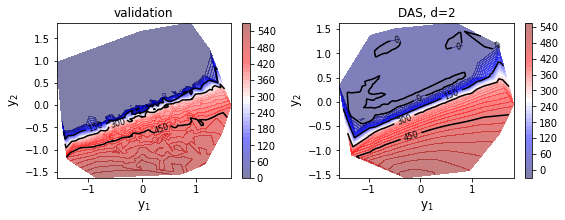

In [13]:
from HIV_model import *

# generate validation samples
n_mc = 1000
x_val = np.random.rand(n_mc, D) * 2 - 1
val_samples = Tcells(x_val, np.linspace(1, times[-1], times[-1]))[:, times-1]
y_val = np.dot(W_1.T, x_val.T).T

I = -1
# validation plot
fig = plt.figure(figsize=[8, 3.16])
ax = fig.add_subplot(121, title='validation')
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'$y_2$', fontsize=12)
contours = ax.tricontour(y_val[:, 0], y_val[:, 1], val_samples[:, I], 4, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
ct = ax.tricontourf(y_val[:, 0], y_val[:, 1], val_samples[:, I], 50, origin='lower',
           cmap='seismic', alpha=0.5)
plt.colorbar(ct)

# DAS plot
ax = fig.add_subplot(122, title='DAS, d=%d' %d)
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'$y_2$', fontsize=12)
contours = ax.tricontour(y_das[:, 0], y_das[:, 1], das_samples[:, I], 4, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
ct = ax.tricontourf(y_das[:, 0], y_das[:, 1], das_samples[:, I], 50, origin='lower',
           cmap='seismic', alpha=0.5)
plt.colorbar(ct)

plt.tight_layout()

### Recreate the C heat maps

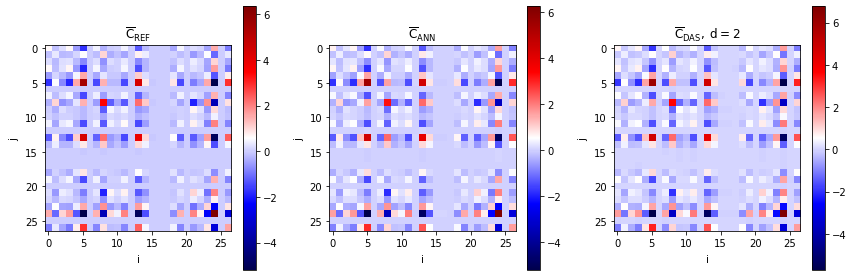

In [14]:
#####################################
# plot a heat map of the C matrices #
#####################################

fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(131, title=r'$\overline{C}_{REF}$', xlabel='$i$', ylabel='$j$')
im = ax1.imshow(C_ref)
plt.colorbar(im)
ax2 = fig.add_subplot(132, title=r'$\overline{C}_{ANN}$', xlabel='$i$', ylabel='$j$')
im = ax2.imshow(C_ann)
plt.colorbar(im)
ax3 = fig.add_subplot(133, title=r'$\overline{C}_{DAS},\; d=%d$' % d, xlabel='$i$', ylabel='$j$')
im = ax3.imshow(C_das)
plt.colorbar(im)
plt.tight_layout()

### Gobal derivative-based sensitivity plots (not in article)

In [19]:
def sensitivity(idx, V_i, **kwargs):
    # Parameter names
    param_names = np.array([r'$s_1$', r'$s_2$', r'$s_3$', r'$p_1$', r'$C_1$', r'$K_1$', r'$K_2$', r'$K_3$',
                   r'$K_4$', r'$K_5$', r'$K_6$', r'$K_7$', r'$K_8$', r'$K_9$', r'$K_{10}$',
                   r'$K_{11}$', r'$K_{12}$', r'$K_{13}$', r'$\delta_1$', r'$\delta_2$',
                   r'$\delta_3$', r'$\delta_4$', r'$\delta_5$', r'$\delta_6$', r'$\delta_7$', r'$\alpha_1$',
                   r'$\psi$'])
    
    fig = plt.figure(figsize=[4, 8])
    ax = fig.add_subplot(111, title=kwargs.get('title', ''))
    # ax.set_ylabel(r'$\int\left(\frac{\partial f}{\partial x_i}\right)^2 p({\bf x})d{\bf x}$', fontsize=14)
    ax.set_xlabel(r'$\nu_i$', fontsize=14)    
    ax.barh(range(V_i.size), width = V_i[idx].flatten(), color = 'dodgerblue')
    ax.set_yticks(range(V_i.size))
    ax.set_yticklabels(param_names[idx[0]], fontsize=14)
    # plt.xticks(rotation=90)
    ax.invert_yaxis()
    sns.despine(top=True)
    plt.tight_layout()

Creating DAS_analysis object
Creating ANN_analysis object
[-0.01582139 -0.00651914 -0.01655712 -0.0075998   0.00358325  0.0302676
 -0.00460845 -0.00596133 -0.0287149   0.01332452 -0.02403023 -0.00633723
 -0.00264664 -0.03064808  0.002386    0.01939683 -0.04090787  0.04339901
 -0.01928816 -0.00099121  0.01926883 -0.01506905 -0.0222922   0.01059347
 -0.02453501 -0.00055428  0.0177155 ]
Parameters ordered from most to least important:
[[24  5 13  8 26 23 11 21  3  0 19  7 14  4  1  9  2 18 22 10 15 16 25 17
   6 12 20]]
Parameters ordered from most to least important:
[[24  5 13  8 26 23 21  0  3 11  4 19  9 14  7  1 18  2 22 10 16  6 20 12
  15 25 17]]
Parameters ordered according to the reference activity score
[[24  5 13  8 26 21 23  3  0 11  4  9 14 19  7  1 18  2 22 10 16 15 17 20
  25  6 12]]


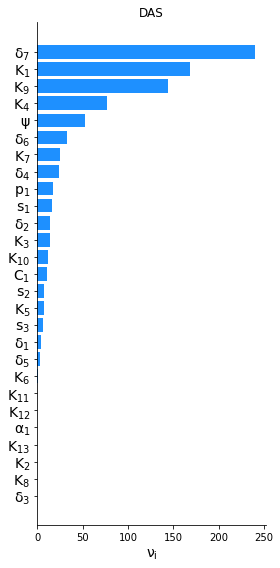

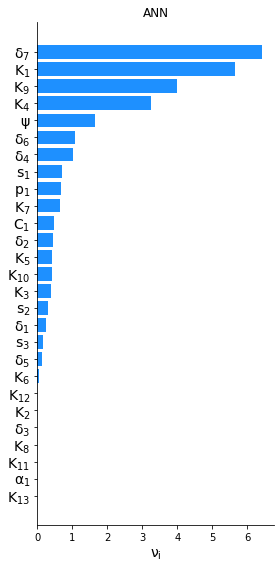

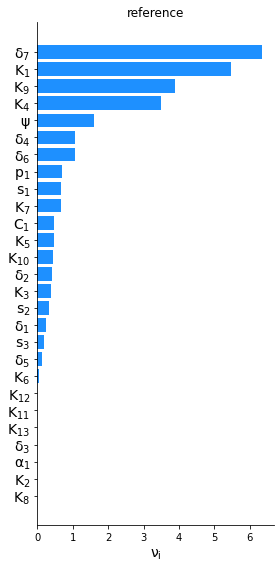

In [20]:
#####################################
# global gradient-based sensitivity #
#####################################

das_analysis = es.analysis.DAS_analysis(das_surrogate)
ann_analysis = es.analysis.ANN_analysis(ann_surrogate)

idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
sensitivity(idx, V_i, title = 'DAS')

idx, V_i = ann_analysis.sensitivity_measures(params, norm=False)
sensitivity(idx, V_i, title = 'ANN')

print('Parameters ordered according to the reference activity score')
V_i_ref = np.diag(C_ref)
idx_ref = np.flipud(np.argsort(np.diag(C_ref))).reshape([1, -1])
print(idx_ref)
sensitivity(idx_ref, V_i_ref, title='reference')